# One-dimensional rainfall infiltration

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

You can execute this notebook interactively →  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/rainfall_infiltration_1D.ipynb)  or  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AppliedMechanics-EAFIT/soil_mechanics/main?filepath=notebooks/rainfall_infiltration_1D.ipynb)

This notebook runs the infiltration models of ``TRIGRS`` (Transient Rainfall Infiltration and Grid-Based Regional Slope-Stability Analysis), developed by [Baum et al., (2002)](https://doi.org/10.3133/ofr02424) and [Baum et al., (2008)](https://doi.org/10.3133/ofr20081159), and parallelized later by [Alvioli & Baum (2016)](https://doi.org/10.1016/j.envsoft.2016.04.002).



## Required modules and global setup for plots

In [1]:
import os
import subprocess
import textwrap
import itertools
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# Figures setup
%matplotlib widget
# plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "DejaVu Serif",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

## Creating directories

In [2]:
# Create a folder called TRIGRS in the current working directory if it doesn't exist
workdir = os.getcwd()
exec_dir = os.path.join(workdir, "TRIGRS_1")
os.makedirs(f"{exec_dir}", exist_ok=True)  

# Create a folder inside TRIGRS to store the ascii files
inputs_dir = os.path.join(exec_dir, "inputs")
outputs_dir = os.path.join(exec_dir, "outputs")
os.makedirs(f"{inputs_dir}", exist_ok=True)
os.makedirs(f"{outputs_dir}", exist_ok=True)

## Functions

In [3]:
def tpx_in_maker(tpx_inputs):
    tpx_in_template = textwrap.dedent(
        f"""\
        TopoIndex 1.0.15; Name of project (up to 255 characters)
        TopoIndex analysis - Project: {tpx_inputs["proj_name"]}
        Flow-direction numbering scheme (ESRI=1, TopoIndex=2)
        {tpx_inputs["flow_dir_scheme"]}
        Exponent, Number of iterations
        {tpx_inputs["exponent_weight_fact"]}, {tpx_inputs["iterarions"]}
        Name of elevation grid file
        TRIGRS_1/inputs/dem.asc
        Name of direction grid
        TRIGRS_1/inputs/directions.asc
        Save listing of D8 downslope neighbor cells (TIdsneiList_XYZ)?  Enter T (.true.) or F (.false.)
        T
        Save grid of D8 downslope neighbor cells (***TIdscelGrid_XYZ)? Enter T (.true.) or F (.false.)
        T
        Save cell index number grid (TIcelindxGrid_XYZ)?  Enter T (.true.) or F (.false.)
        T
        Save list of cell number and corresponding index number (***TIcelindxList_XYZ)? Enter T (.true.) or F (.false.)
        T
        Save flow-direction grid remapped from ESRI to TopoIndex (TIflodirGrid_XYZ)? Enter T (.true.) or F (.false.)
        T
        Save grid of points on ridge crests (TIdsneiList_XYZ)? Enter T (.true.) or F (.false.); Sparse (T) or dense (F)?
        F,T
        ID code for output files? (8 characters or less)
        {tpx_inputs["proj_name"]}"""
    )
    with open("tpx_in.txt", "w") as file:
        file.write(tpx_in_template)
    return


def run_topoidx(tpx_inputs):
    tpx_in_maker(tpx_inputs)  # Generating initializing files
    subprocess.call(["chmod +x ./TRIGRS_1/Exe_TopoIndex"], shell=True)  # Change permission
    subprocess.call(["./TRIGRS_1/Exe_TopoIndex"])  # Running Fortran executable
    # Moving log file to outputs folder and renaming it
    os.rename(os.path.join(workdir, "TopoIndexLog.txt"), os.path.join(outputs_dir, f"TopoIndexLog_{tpx_inputs['proj_name']}.txt"))
    os.rename(os.path.join(workdir, "tpx_in.txt"), os.path.join(exec_dir, f"tpx_in_{tpx_inputs['proj_name']}.txt"))
    return


def tr_in_maker(trg_inputs):
    # Create text block for geotechnical parameters of each zone
    geoparams = ""
    for zone in trg_inputs["geoparams"].keys():
        z = trg_inputs["geoparams"][zone]
        # print(zone, z)
        txt_zone = "".join(
            [
                f"zone, {zone}\n",
                "cohesion, phi, uws, diffus, K-sat, Theta-sat, Theta-res, Alpha\n",
                f'{z["c"]}, {z["φ"]}, {z["γ_sat"]}, {z["D_sat"]}, {z["K_sat"]}, {z["θ_sat"]}, {z["θ_res"]}, {z["α"]}\n',
            ]
        )
        geoparams = str().join([geoparams, txt_zone])
    # print(geoparams)
    # trg_inputs['geoparams'] = geoparams
    # Update rifil entry with placeholder for each file
    trg_inputs["rifil"] = str().join(
        [f"TRIGRS_1/inputs/ri{n}.asc\n" for n in range(1, len(trg_inputs["capt"]))]
    )

    # Template
    trg_in_template = (
        textwrap.dedent(
            f"""\
        Project: {trg_inputs['proj_name']}
        TRIGRS, version 2.1.00c, (meter-kilogram-second-degrees units)
        tx, nmax, mmax, zones
        {trg_inputs['tx']}, {trg_inputs['nmax']}, {trg_inputs['mmax']}, {trg_inputs['zones']}
        nzs, zmin, uww, nper t
        {trg_inputs['nzs']}, 0.001, 9.8e3, {trg_inputs['nper']}, {trg_inputs['t']}
        zmax, depth, rizero, Min_Slope_Angle (degrees), Max_Slope_Angle (degrees)
        {trg_inputs['zmax']}, {trg_inputs['depth']}, {trg_inputs['rizero']}, 0., 90.0
        """
        )
        + geoparams[:-1]
        + textwrap.dedent(
            f"""
        cri(1), cri(2), ..., cri(nper)
        {', '.join(map(str, trg_inputs['cri']))}
        capt(1), capt(2), ..., capt(n), capt(n+1)
        {', '.join(map(str, trg_inputs['capt']))}
        File name of slope angle grid (slofil)
        TRIGRS_1/inputs/slope.asc
        File name of digital elevation grid (elevfil)
        TRIGRS_1/inputs/dem.asc
        File name of property zone grid (zonfil)
        TRIGRS_1/inputs/zones.asc
        File name of depth grid (zfil)
        TRIGRS_1/inputs/zmax.asc
        File name of initial depth of water table grid   (depfil)
        TRIGRS_1/inputs/depthwt.asc
        File name of initial infiltration rate grid   (rizerofil)
        TRIGRS_1/inputs/rizero.asc
        List of file name(s) of rainfall intensity for each period, (rifil())
        """
        )
        + trg_inputs["rifil"][:-2]
        + textwrap.dedent(
            f"""
        File name of grid of D8 runoff receptor cell numbers (nxtfil)
        TRIGRS_1/inputs/TIdscelGrid_{trg_inputs['proj_name']}.txt
        File name of list of defining runoff computation order (ndxfil)
        TRIGRS_1/inputs/TIcelindxList_{trg_inputs['proj_name']}.txt
        File name of list of all runoff receptor cells  (dscfil)
        TRIGRS_1/inputs/TIdscelList_{trg_inputs['proj_name']}.txt
        File name of list of runoff weighting factors  (wffil)
        TRIGRS_1/inputs/TIwfactorList_{trg_inputs['proj_name']}.txt
        Folder where output grid files will be stored  (folder)
        TRIGRS_1/outputs/
        Identification code to be added to names of output files (suffix)
        {trg_inputs['proj_name']}
        Save grid files of runoff? Enter T (.true.) or F (.false.)
        F
        Save grid of minimum factor of safety? Enter T (.true.) or F (.false.)
        T
        Save grid of depth of minimum factor of safety? Enter T (.true.) or F (.false.)
        T
        Save grid of pressure head at depth of minimum factor of safety? Enter T (.true.) or F (.false.)
        T
        Save grid of computed water table depth or elevation? Enter T (.true.) or F (.false.) followed by 'depth,' or 'eleva'
        T, depth
        Save grid files of actual infiltration rate? Enter T (.true.) or F (.false.)
        F
        Save grid files of unsaturated zone basal flux? Enter T (.true.) or F (.false.)
        F
        Save listing of pressure head and factor of safety ("flag")? (-9 sparse xmdv , -8 down-sampled xmdv, -7 full xmdv, -6 sparse ijz, -5 down-sampled ijz, -4 full ijz, -3 Z-P-Fs-saturation list -2 detailed Z-P-Fs, -1 Z-P-Fs list, 0 none). Enter flag value followed by down-sampling interval (integer).
        {trg_inputs['ψ_flag']}, {trg_inputs['nzs']}
        Number of times to save output grids and (or) ijz/xmdv files
        {trg_inputs['n_outputs']}
        Times of output grids and (or) ijz/xmdv files
        {', '.join(map(str, trg_inputs['t_n_outputs']))}
        Skip other timesteps? Enter T (.true.) or F (.false.)
        F
        Use analytic solution for fillable porosity?  Enter T (.true.) or F (.false.)
        T
        Estimate positive pressure head in rising water table zone (i.e. in lower part of unsat zone)?  Enter T (.true.) or F (.false.)
        T
        Use psi0=-1/alpha? Enter T (.true.) or F (.false.) (False selects the default value, psi0=0)
        F
        Log mass balance results?   Enter T (.true.) or F (.false.)
        T
        Flow direction (Enter "gener", "slope", or "hydro")
        {trg_inputs['flowdir']}
        Add steady background flux to transient infiltration rate to prevent drying beyond the initial conditions during periods of zero infiltration?
        T
        Specify file extension for output grids. Enter T (.true.) for ".asc" or F for ".txt"
        T
        Ignore negative pressure head in computing factor of safety (saturated infiltration only)?   Enter T (.true.) or F (.false.)
        T
        Ignore height of capillary fringe in computing pressure head for unsaturated infiltration option?   Enter T (.true.) or F (.false.)
        T
        Parameters for deep pore-pressure estimate in SCOOPS ijz output: Depth below ground surface (positive, use negative value to cancel this option), pressure option (enter 'zero' , 'flow' , 'hydr' , or 'relh')
        -50.0,flow
        """
        )
    )
    # Create txt file
    with open("tr_in.txt", "w") as file:
        file.write(trg_in_template)
    return


def run_trigrs(trg_inputs):
    # Correcting sign for `Alpha` parameters for saturated/unsaturated models
    for z in trg_inputs["geoparams"].keys():
        zone = trg_inputs["geoparams"][z]
        if "S" in trg_inputs["model"]:
            zone["α"] = -1 * abs(zone["α"])
        else:
            zone["α"] = abs(zone["α"])

    # Correcting sign for `mmax` parameters for finite/infinite models
    if "I" in trg_inputs["model"]:
        trg_inputs["mmax"] = -1 * abs(trg_inputs["mmax"])
    else:
        trg_inputs["mmax"] = abs(trg_inputs["mmax"])

    # Generating initializing file and running TRIGRS executable
    tr_in_maker(trg_inputs)  # Initializing files from template
    if trg_inputs["parallel"]:
        exe = "./TRIGRS_1/Exe_TRIGRS_par"
        subprocess.call([f"chmod +x {exe}"], shell=True)  # Change permission
        subprocess.call(
            [f'mpirun -np {trg_inputs["NP"]} {exe}'], shell=True
        )  # Running TRIGRS executable
    else:
        exe = "./TRIGRS_1/Exe_TRIGRS_ser"
        subprocess.call([f"chmod +x {exe}"], shell=True)  # Change permission
        subprocess.call([exe], shell=True)  # Running TRIGRS executable

    # Moving files to output folders and renaming it
    proj_name, model = trg_inputs["proj_name"], trg_inputs["model"]
    # os.rename(
    #     "TrigrsLog.txt",
    #     f"TRIGRS_1/outputs/log_files/TrigrsLog_{proj_name}_{model}.txt",
    # )
    os.rename(os.path.join(workdir, "TrigrsLog.txt"), os.path.join(outputs_dir, f"TrigrsLog_{proj_name}_{model}.txt"))
    # os.rename("tr_in.txt", f"TRIGRS_1/tr_in_{proj_name}_{model}.txt")
    os.rename(os.path.join(workdir, "tr_in.txt"), os.path.join(exec_dir, f"tr_in_{proj_name}_{model}.txt"))
    groups = (
        "TRfs_min",
        "TRp_at_fs_min",
        "TRwater_depth",
        "TRz_at_fs_min",
        "TR_ijz_p_th",
        # "TRrunoffPer",
    )
    [os.makedirs(f"TRIGRS_1/outputs/{grp}", exist_ok=True) for grp in groups]
    idx = np.arange(1, trg_inputs["n_outputs"] + 1, 1)
    for grp, i in itertools.product(groups, idx):
        if grp == "TRrunoffPer":
            os.rename(
                f"TRIGRS_1/outputs/{grp}{i}{proj_name}.asc",
                f"TRIGRS_1/outputs/{grp}/{grp}_{proj_name}_{model}_{i}.asc",
            )
        elif grp == "TR_ijz_p_th":
            os.rename(
                f"TRIGRS_1/outputs/{grp}_{proj_name}_{i}.txt",
                f"TRIGRS_1/outputs/{grp}/{grp}_{proj_name}_{model}_{i}.txt",
            )
        else:
            os.rename(
                f"TRIGRS_1/outputs/{grp}_{proj_name}_{i}.asc",
                f"TRIGRS_1/outputs/{grp}/{grp}_{proj_name}_{model}_{i}.asc",
            )
    return


def get_param(zone, param):
    return trg_inputs['geoparams'][zone.iloc[0]][param]

def get_df(file):
    γ_w = 9.8e3  # [N/m3] unit weight of water
    # Reading file
    df = pd.read_csv(file,
                     names=['i_tr', 'j_tr', 'elev', 'ψ', 'θ'],
                     skiprows=7, sep='\s+')#delim_whitespace=True)
    # Correcting indices to match numpy notation
    df['i'] = df['j_tr'].max() - df['j_tr']
    df['j'] = df['i_tr'] - 1
    df.drop(columns=['i_tr', 'j_tr'], inplace=True)
    # Calculating depths from elevations
    elev_max = df.groupby(['i', 'j'])['elev'].transform('max')
    df['z'] = elev_max - df['elev'] + 0.001
    df = df[['i', 'j', 'elev', 'z', 'ψ', 'θ']]
    # Assigning zones and geotechnical parameters
    df['zone'] = zones[df['i'], df['j']]
    for param_name in trg_inputs['geoparams'][1].keys():
        df[param_name] = df.groupby('zone')['zone'].transform(
            get_param, param=param_name)
    # Correting rows with ψ==0 (watertable) due to numerical errors
    mask = (df['ψ'] == 0) & (df['z'] > 0.001) & (df['θ'] == df['θ_sat'])
    # df.loc[mask, 'z'] = df.loc[mask, 'z'] + 1/df.loc[mask, 'α']
    # df.loc[mask, 'elev'] = df.loc[mask, 'elev'] - 1/df.loc[mask, 'α']
    # df.sort_values(['i', 'j', 'z'], inplace=True)
    df.drop(df[mask].index, inplace=True)  # This eliminates the wt rows
    # Assigning slope
    df['δ'] = slope[df['i'], df['j']]
    δrad = np.deg2rad(df['δ'])
    # Calculating effective stress parameter, χ
    df['χ'] = (df['θ'] - df['θ_res']) / (df['θ_sat'] - df['θ_res'])
    # Specific gravity
    df['Gs'] = (df['γ_sat']/γ_w - df['θ_sat']) / (1 - df['θ_sat'])
    # unit weight at unsat and sat zones
    df['γ_nat'] = (df['Gs'] * (1 - df['θ_sat']) + df['θ']) * γ_w
    # average unit weight
    γ_cumul = df.groupby(['i', 'j'])['γ_nat'].transform('cumsum')
    idx = df.groupby(['i', 'j'])['γ_nat'].cumcount() + 1
    df['γ_avg'] = γ_cumul / idx
    # Factor of safety
    fs1 = np.tan(np.deg2rad(df['φ'])) / np.tan(δrad)
    fs2_num = df['c'] - df['ψ'] * γ_w * df['χ'] * np.tan(np.deg2rad(df['φ']))
    fs2_den = df['γ_avg'] * df['z'] * np.sin(δrad) * np.cos(δrad)
    fs = fs1 + fs2_num/fs2_den
    fs[fs > 3] = 3
    df['fs'] = fs
    return df

## Loading executables and input files

In [4]:
def download_file_from_github(file, url_path, output_path):
    url = f"{url_path}/{file}"
    response = requests.get(url)  # Send a GET request to the URL
    if response.status_code == 200:  # Check if the request was successful
        output_path = f"{output_path}/{file}"
        with open(output_path, 'wb') as file:  # Write the content to a file
            file.write(response.content)
        print(f"File downloaded successfully and saved to {output_path}")
    else:
        print(f"Failed to download file. HTTP status code: {response.status_code}")


url_path = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/trigrs/"  # URL of the raw file on GitHub
output_path = "./TRIGRS_1/"  # Path where you want to save the downloaded file

### TopoIndex

In [5]:
file = "Exe_TopoIndex"  # Name of the file to download
download_file_from_github(file, url_path, output_path)

File downloaded successfully and saved to ./TRIGRS_1//Exe_TopoIndex


### TRIGRS

In [6]:
file = "Exe_TRIGRS_ser"  # Name of the file to download
download_file_from_github(file, url_path, output_path)

File downloaded successfully and saved to ./TRIGRS_1//Exe_TRIGRS_ser


In [7]:
# Check the files in the executables folder
os.listdir(exec_dir)

['Exe_TopoIndex',
 'Exe_TRIGRS_ser',
 'inputs',
 'outputs',
 'tpx_in_ONE_CELL.txt',
 'tr_in_ONE_CELL_UF.txt']

## Running a case

### General inputs

In [8]:
proj_name = "ONE_CELL"
slope = 0.0  # [°]
zmax = 1.0  # [m]
depth_wt = 1.0  # [m]
model = "UF"  # Choose one among UF, UI, SF, SI → | U: unsaturated | S: saturated | F: finite | I: infinite |
rainfall_int =  [5.0] # [mm/h]
cumul_duration = [0, 24] # [h]  Always starts at 0 and contains n+1 elements, where n is the number of rainfall intensities values
output_times = [0, 3, 6, 9, 12, 15, 18, 21, 24] # [h]  It does not have to include the same values as cumul_duration

### Units conversion

In [9]:
# Do not edit this cell
rainfall_int =  np.array(rainfall_int) / 36e5  # [mm/h] to [m/s]
cumul_duration = np.array(cumul_duration) * 3600  # [h] to [s]
output_times = np.array(output_times) * 3600  # [h] to [s]

### TRIGRS inputs

Do not edit those parameters with the → 🛇 ← symbol.

In [10]:
trg_inputs = {
    "proj_name": proj_name,  # Name of the project  → 🛇 ←
    "model": model,  # S-saturated or U-unsaturated + F-finite or I-infinite   → 🛇 ←
    "tx": 20, # [] tx*nper determines how many time steps are used in the computations  → 🛇 ←
    "nmax": 30,  # [] Ma number of roots 𝚲n and terms in series solutions for UNS.zone  → 🛇 ←
    "mmax": 100,  # [] Max number of terms in series solution for FIN depth. If <0: INF depth  → 🛇 ←
    "zones": 1,  # [] Number of zones  → 🛇 ←
    "nzs": 20,  # [] Vertical increments until zmax  → 🛇 ←
    "nper": len(rainfall_int),  # [-] Periods of rainfall (N)  → 🛇 ←
    "t": cumul_duration[-1],  # [s] Elapsed time since the start of the storm (t)  → 🛇 ←
    "zmax": zmax + .01,  # [m] Max. depth to compute Fs and Ψ (if <0 read from grid file)  → 🛇 ←
    "depth": depth_wt + 0.01,  # [m] Water table depth (d) (if <0 read from grid file)  → 🛇 ←
    "rizero": 1.5e-7,  # [m/s] Steady pre-storm and long-term infilt. (Izlt) (if <0 read from grid file)
    "geoparams":{
        1: {
            "c": 3e3,  # [Pa] soil cohesion for effective stress (c')
            "φ": 33.6,  # [deg] soil friction angle for effective stress (φ')
            "γ_sat": 20.0e3,  # [N/m3]  unit weight of soil (γs)
            "D_sat": 5.0e-5,  # [m2/s] Saturated hydraulic diffusivity (D0)
            "K_sat": 1.0e-5,  # [m/s] Saturated hydraulic conductivity (Ks)
            "θ_sat": 0.41,  # [-] Saturated water content (θs)
            "θ_res": 0.06,  # [-] Residual water content (θr)
            "α": 3,  # [1/m] Fitting parameter. If <0: saturated infiltration
        }
    },
    "cri": tuple(rainfall_int),  # [m/s] Rainfall intensities  (Inz)  → 🛇 ←
    "capt": tuple(cumul_duration),  # [s] Cumulative duration of rainfall cri[i]  → 🛇 ←
    "flowdir": "gener",  # Method for maximum allowed Ψ ("gener", "slope", or "hydro"))  → 🛇 ←
    "n_outputs": len(output_times),  # [-] No of raster outputs at different t  → 🛇 ←
    "t_n_outputs": tuple(output_times),#t,  # [s] Time at which to save raster files  → 🛇 ←
    "ψ_flag": -4,  # → 🛇 ←
    "parallel": False,  # [-] Run in parallel  → 🛇 ←
    "NP" : 4, # Number of processors  → 🛇 ←
    # "inz_n_outputs": inz_n_outputs #inz,  # [s] Rainfall intensities at which to save raster files
}


### Creating `.asc` files

In [11]:
for file in ['dem', 'zmax', 'depthwt', 'slope', 'directions', 'zones']:
    with open(f"{inputs_dir}/{file}.asc", "w") as asc:
        asc.write("ncols         1\n")
        asc.write("nrows         1\n")
        asc.write("xllcorner     0\n")
        asc.write("yllcorner     0\n")
        asc.write("cellsize      1\n")
        asc.write("NODATA_value  -9999\n")
        asc.write("0\n")

def mod_asc(file, new_val):
    with open(f'{inputs_dir}/{file}.asc', 'r') as asc:
        lines = asc.readlines()
    with open(f'{inputs_dir}/{file}.asc', 'w') as asc:
        lines[6] = str(new_val) + '\n'
        asc.writelines(lines)
    return

# Set the values for the ascii input files
mod_asc('dem', 0)
mod_asc('zmax', zmax)
mod_asc('depthwt', depth_wt)
mod_asc('slope', slope)
mod_asc('directions', 1)
mod_asc('zones', 1)


### Runnig TopoIndex and TRIGRS

In [12]:
# Running TopoIndex
tpx_inputs = {
    "flow_dir_scheme": 2,
    "exponent_weight_fact": -1,
    "iterarions": 10,
    "proj_name": proj_name,
}
run_topoidx(tpx_inputs)

   TopoIndex: Topographic Indexing and
  flow distribution factors for routing
  runoff through Digital Elevation Models
             By Rex L. Baum
        U.S. Geological Survey
      Version 1.0.14, 11May2015
 -----------------------------------------
 
 TopoIndex analysis - Project: ONE_CELL
           1  = number of data cells
           1  = total number of cells
 Reading elevation grid data
 Initial elevation indexing completed
 Finding D8 neighbor cells
 nxtcel() nodata (integer,floating)=        -9999  -9999.00000    
 Identifying downslope cells and grid mismatches
 No grid mismatch found!
 Correcting cell index numbers
 Computing weighting factors
 Saving results to disk


In [13]:
run_trigrs(trg_inputs)

 
 TRIGRS: Transient Rainfall Infiltration
 and Grid-based Regional Slope-Stability
                Analysis
        Version 2.1.00c, 02 Feb 2022
   By Rex L. Baum and William Z. Savage
        U.S. Geological Survey
 -----------------------------------------
 
 Opening default initialization file
 TRIGRS, version 2.1.00c, (meter-kilogram-second-degrees units)                                                                                                                                                                                                 
 Unsaturated infiltration model selected for cells in zone           1 .
 ******** Zone            1  *********
 Using unsaturated infiltration model.
 ********  ********  ********  *********
 TRIGRS_1/inputs/TIgrid_size.txt F
 TRIGRS_1/inputs/GMgrid_size.txt F
 TRIGRS_1/inputs/TRgrid_size.txt T
 Reading input grids
 One property zone, no grid required!
 Testing and adjusting steady infiltration rates
 Adjusted steady infiltration rate at  

 TRIGRS finished!


STOP 0


## Output to dataframe

In [14]:
zones = np.loadtxt(f'{inputs_dir}/zones.asc', skiprows=6)
zones = zones.reshape((1, 1)) if zones.ndim == 0 else zones
slope = np.loadtxt(f'{inputs_dir}/slope.asc', skiprows=6)
slope = slope.reshape((1, 1)) if slope.ndim == 0 else slope
trg_inputs['geoparams'][zones[0, 0]]

{'c': 3000.0,
 'φ': 33.6,
 'γ_sat': 20000.0,
 'D_sat': 5e-05,
 'K_sat': 1e-05,
 'θ_sat': 0.41,
 'θ_res': 0.06,
 'α': 3}

In [15]:
def get_param(zone, param):
    return trg_inputs['geoparams'][zone.iloc[0]][param]

def get_df(file):
    γ_w = 9.8e3  # [N/m3] unit weight of water
    # Reading file
    df = pd.read_csv(file, names=['i_tr', 'j_tr', 'elev', 'ψ', 'θ'], skiprows=7, sep='\s+')
    # Correcting indices to match numpy notation
    df['i'] = df['j_tr'].max() - df['j_tr']
    df['j'] = df['i_tr'] - 1
    df.drop(columns=['i_tr', 'j_tr'], inplace=True)
    # Calculating depths from elevations
    elev_max = df.groupby(['i', 'j'])['elev'].transform('max')
    df['z'] = elev_max - df['elev'] + 0.001
    df = df[['i', 'j', 'elev', 'z', 'ψ', 'θ']]
    # Assigning zones and geotechnical parameters
    df['zone'] = zones[df['i'], df['j']]
    for param_name in trg_inputs['geoparams'][1].keys():
        df[param_name] = df.groupby('zone')['zone'].transform(get_param, param=param_name)
    # Correting rows with ψ==0 (watertable) due to numerical errors
    mask = (df['ψ'] == 0) & (df['z'] > 0.001) & (df['θ'] == df['θ_sat'])
    # df.loc[mask, 'z'] = df.loc[mask, 'z'] + 1/df.loc[mask, 'α']
    # df.loc[mask, 'elev'] = df.loc[mask, 'elev'] - 1/df.loc[mask, 'α']
    # df.sort_values(['i', 'j', 'z'], inplace=True)
    df.drop(df[mask].index, inplace=True)  # This eliminates the wt rows
    # Assigning slope
    df['δ'] = slope[df['i'], df['j']]
    δrad = np.deg2rad(df['δ'])
    # Calculating effective stress parameter, χ
    df['χ'] = (df['θ'] - df['θ_res']) / (df['θ_sat'] - df['θ_res'])
    # Specific gravity
    df['Gs'] = (df['γ_sat']/γ_w - df['θ_sat']) / (1 - df['θ_sat'])
    # unit weight at unsat and sat zones
    df['γ_nat'] = (df['Gs'] * (1 - df['θ_sat']) + df['θ']) * γ_w
    # average unit weight
    γ_cumul = df.groupby(['i', 'j'])['γ_nat'].transform('cumsum')
    idx = df.groupby(['i', 'j'])['γ_nat'].cumcount() + 1
    df['γ_avg'] = γ_cumul / idx
    # Factor of safety
    fs1 = np.tan(np.deg2rad(df['φ'])) / np.tan(δrad)
    fs2_num = df['c'] - df['ψ'] * γ_w * df['χ'] * np.tan(np.deg2rad(df['φ']))
    fs2_den = df['γ_avg'] * df['z'] * np.sin(δrad) * np.cos(δrad)
    fs = fs1 + fs2_num/fs2_den
    fs[fs > 3] = 3
    df['fs'] = fs
    return df

# Processing file
file = f'{outputs_dir}/TR_ijz_p_th/TR_ijz_p_th_{proj_name}_{model}_2.txt'
df = get_df(file)
# df

## Results verification

In [16]:
cell = (0, 0)  # (i, j) indices of the unique cell in the domain

file = f'{outputs_dir}/TR_ijz_p_th/TR_ijz_p_th_{proj_name}_{model}_4.txt'
df = get_df(file)
cell_df = df[(df['i']==0) & (df['j']==0)]
# cell_df.drop(cell.index[cell['ψ'] == 0], inplace=True)
cell_df

,i,j,elev,z,ψ,θ,zone,c,φ,γ_sat,...,K_sat,θ_sat,θ_res,α,δ,χ,Gs,γ_nat,γ_avg,fs
0,0,0,-0.00100,0.00100,-0.56110,0.1250,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.185714,2.764095,17207.00,17207.000000,3.0
1,0,0,-0.05145,0.05145,-0.55170,0.1269,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.191143,2.764095,17225.62,17216.310000,3.0
2,0,0,-0.10190,0.10190,-0.54080,0.1291,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.197429,2.764095,17247.18,17226.600000,3.0
3,0,0,-0.15235,0.15235,-0.52810,0.1318,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.205143,2.764095,17273.64,17238.360000,3.0
4,0,0,-0.20280,0.20280,-0.51360,0.1350,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.214286,2.764095,17305.00,17251.688000,3.0
5,0,0,-0.25325,0.25325,-0.49700,0.1388,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.225143,2.764095,17342.24,17266.780000,3.0
6,0,0,-0.30370,0.30370,-0.47830,0.1433,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.238000,2.764095,17386.34,17283.860000,3.0
7,0,0,-0.35415,0.35415,-0.45740,0.1488,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.253714,2.764095,17440.24,17303.407500,3.0
8,0,0,-0.40460,0.40460,-0.43410,0.1552,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.272000,2.764095,17502.96,17325.580000,3.0
9,0,0,-0.45505,0.45505,-0.40850,0.1628,1.0,3000.0,33.6,20000.0,...,0.00001,0.41,0.06,3,0.0,0.293714,2.764095,17577.44,17350.766000,3.0


## Plotting results at a point

In [17]:
def read_time(file):
    with open(file, 'r') as file:
        lines = file.readlines()
        time = float(lines[4].split()[-1])
    return time

time = read_time(f'{outputs_dir}/TR_ijz_p_th/TR_ijz_p_th_{proj_name}_{model}_2.txt')
time

8640.0

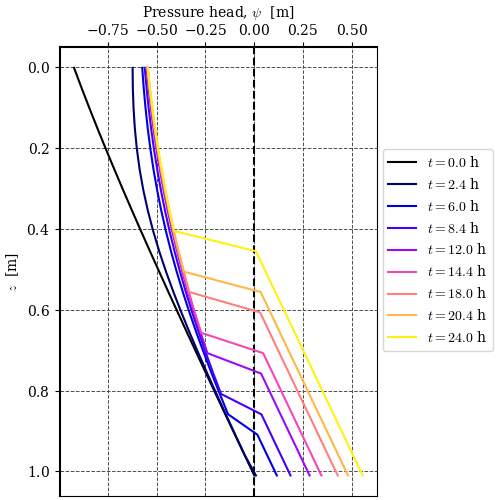

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True, layout='constrained')

palette = mpl.colormaps['gnuplot2']

ax.axvline(0, color='k', lw=1.5, ls='--')
ax.set_prop_cycle('color', palette(np.linspace(0, 1, len(output_times)+1)))
for n in np.arange(len(output_times)) + 1:
    file = f'TRIGRS_1/outputs/TR_ijz_p_th/TR_ijz_p_th_{proj_name}_{model}_{n}.txt'
    t = read_time(file)
    df = get_df(file)
    df_cell = df[(df['i']==cell[0]) & (df['j']==cell[1])]
    ax.plot(df_cell['ψ'], df_cell['z'], label=f'$t={t/3600:.1f}$ h')

ax.grid(True, color='0.3', ls='--', lw=0.7)
ax.spines["top"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(top=True, bottom=False)
ax.xaxis.set_label_position('top')
ax.set(xlabel='Pressure head, $\\psi$  [m]', ylabel='$z$  [m]')
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside right center')
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()